In [21]:
import os
import re

import numpy as np

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
from transformers import DetrImageProcessor, DetrForObjectDetection

In [9]:
# проверка пар, сбор списка пар

rootdir = "./datasets/405/"
regex_find = re.compile('(.*csv$)|(.*jpg$)')
jpg_list = []
csv_list = []

for root, dirs, files in os.walk(rootdir):
    for file in files:
        if regex_find.match(file):
            temp = os.path.splitext(file)
            if temp[1] == '.jpg':
                name = temp[0] + temp[1]
                clean_name = temp[0].strip() + temp[1]
                if name != clean_name:
                    os.rename(rootdir+'/'+name, rootdir+'/'+clean_name) # убираем лишние пробелы в названиях фото
                jpg_list.append(temp[0])
            else: csv_list.append(temp[0])

for x in jpg_list:
    if x not in csv_list:
        print(f'Отсутствует csv для {x}.jpg')

for x in csv_list:
    if x not in jpg_list:
        print(f'Отсутствует jpg для {x}.csv')

pairs_list = list(set(jpg_list) & set(csv_list))
pairs_list.sort()

Отсутствует csv для 240493.jpg


In [10]:
def cut_in_half(image):
    
    height, width, channels = image.shape
    hei = int(height / 2)
    cut_img = image[hei: height, 0:width]
    
    return cut_img

Фото: 141899.jpg
Detected table with confidence 0.994 at location [78.26, 50.7, 624.01, 282.28]


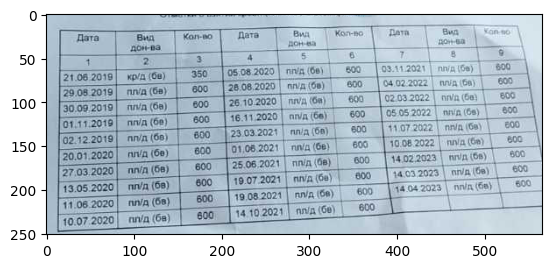

Фото: 204119.jpg
Распознавание не удалось
Фото: 213950.jpg
Detected table with confidence 0.986 at location [249.11, 388.22, 3171.35, 1776.07]


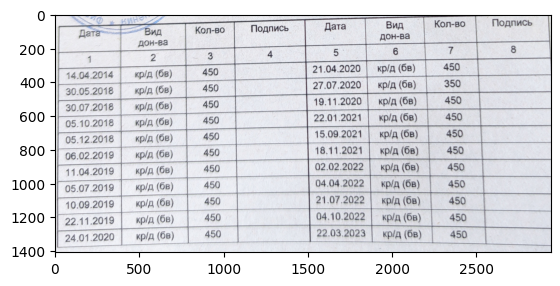

Фото: 225629.jpg
Detected table with confidence 0.993 at location [263.96, 69.35, 2756.61, 806.98]


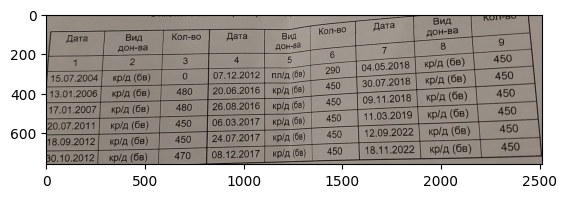

Фото: 227414.jpg
Detected table with confidence 0.988 at location [156.96, 152.54, 1275.57, 522.33]


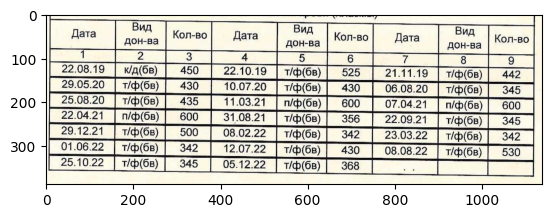

Фото: 228963.jpg
Detected table with confidence 0.994 at location [44.96, 117.42, 697.04, 358.14]


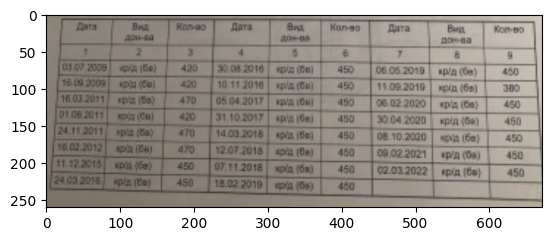

Фото: 231820.jpg
Detected table with confidence 0.99 at location [89.73, 157.58, 1100.54, 412.1]


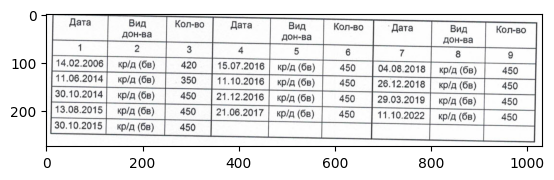

Фото: 233749.jpg
Detected table with confidence 0.996 at location [288.34, 697.86, 2905.72, 1486.7]


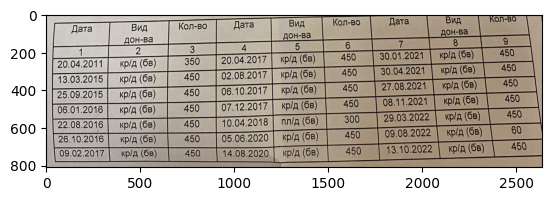

Фото: 236000.jpg
Detected table with confidence 0.993 at location [282.68, 194.78, 2045.68, 501.04]


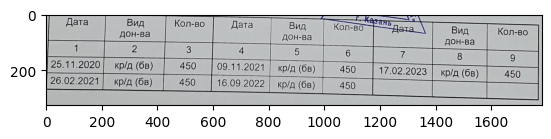

Фото: 238716.jpg
Detected table with confidence 0.994 at location [415.69, 308.02, 2564.84, 1403.22]


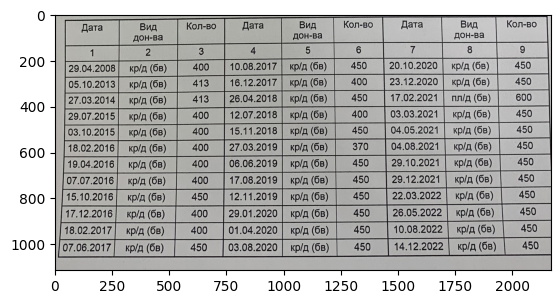

Фото: 243478.jpg
Detected table with confidence 0.996 at location [29.45, 57.55, 428.78, 272.77]


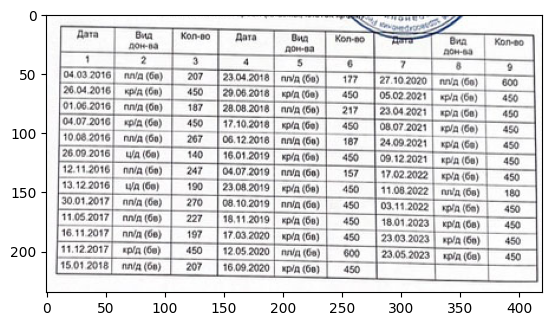

Фото: 245365.jpg
Detected table with confidence 0.993 at location [318.82, 462.02, 2727.9, 1719.05]


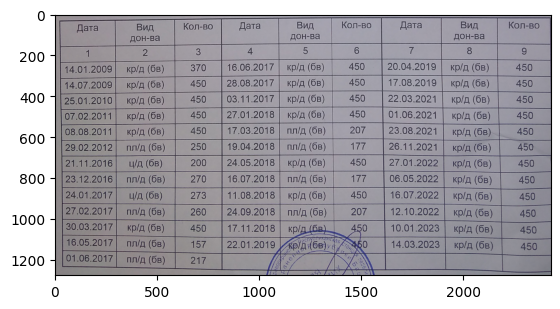

Фото: 254586.jpg
Detected table with confidence 0.995 at location [61.36, 89.36, 648.91, 222.81]


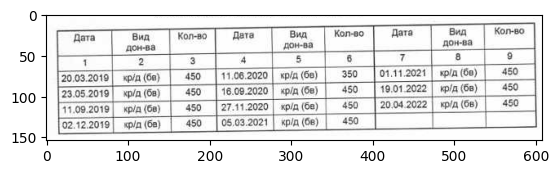

Фото: 256578.jpg
Detected table with confidence 0.947 at location [90.96, 95.71, 574.13, 226.76]


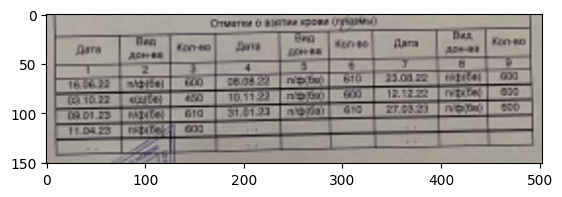

Фото: 256838.jpg
Detected table with confidence 0.995 at location [17.85, 37.88, 544.1, 230.58]


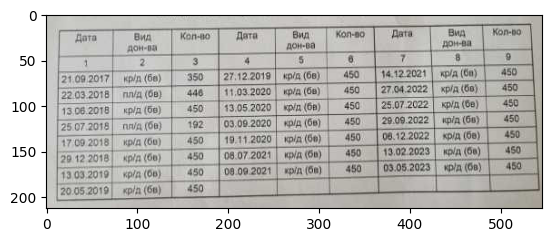

In [23]:
for x in pairs_list:
    file_path = './datasets/405/'+x+'.jpg'
    print('Фото: '+x+'.jpg')
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cut_in_half(image)
    image = Image.fromarray(image)

    processor = DetrImageProcessor.from_pretrained("TahaDouaji/detr-doc-table-detection")
    model = DetrForObjectDetection.from_pretrained("TahaDouaji/detr-doc-table-detection")

    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    # let's only keep detections with score > 0.9
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]
    if len(results['boxes']) > 0:
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            box = [round(i, 2) for i in box.tolist()]
            print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
        )

        pad = [-10, -10, +10, +10]
        padded_box = [x + y for x, y in zip(box, pad)]

        im = image.crop((padded_box))
        plt.imshow(im)
        plt.show();
        im.save('./datasets/detr_processed/'+x+'.jpg')
    else:
        nullim = Image.fromarray(np.zeros((100,100,3)).astype(np.uint8))
        nullim.save('./datasets/detr_processed/'+x+'.jpg')
        print('Распознавание не удалось')

Точность = 0.48182501056064275